In [9]:
import seaborn as sns
import pandas as pd

In [10]:
# Read the JSONL file and load the data into a DataFrame using pandas
name = 'cp_shardq2'
df = pd.read_json(f'{name}.jsonl', lines=True)
df['qo_factor'] = (df['kv_len'] / 1024).astype(int)

In [11]:
# Group the DataFrame by the specified columns and calculate the mean and standard deviation of 'median_compute_time'
aggregated_df = df.groupby(['batch_size', 'qo_factor', 'num_qo_heads', 'num_kv_heads', 'head_dim', 'cp_degree']).agg(
    avg_median_compute_time=('median_compute_time', 'mean'),
    std_median_compute_time=('median_compute_time', 'std'),
    # max_median_compute_time=('median_compute_time', 'max'),
    # min_median_compute_time=('median_compute_time', 'min')
).reset_index()

aggregated_df["value_str"] = aggregated_df.apply(
    lambda row: f"{row['avg_median_compute_time']:.2f} ± {row['std_median_compute_time']:.2f}",
    axis=1
)

# Display the aggregated DataFrame
aggregated_df


,batch_size,qo_factor,num_qo_heads,num_kv_heads,head_dim,cp_degree,avg_median_compute_time,std_median_compute_time,value_str
0,1,8,32,8,128,1,7.554672,NaN,7.55 ± nan
1,1,8,32,8,128,2,5.657152,NaN,5.66 ± nan
2,1,8,32,8,128,4,2.139876,0.001288,2.14 ± 0.00
3,1,8,32,8,128,8,1.310992,NaN,1.31 ± nan
4,1,16,32,8,128,1,29.791024,NaN,29.79 ± nan
...,...,...,...,...,...,...,...,...,...
72,8,64,32,8,128,2,1706.996826,NaN,1707.00 ± nan
73,8,64,32,8,128,4,853.936279,NaN,853.94 ± nan
74,8,64,32,8,128,8,427.806488,NaN,427.81 ± nan
75,8,128,32,8,128,4,3431.684937,NaN,3431.68 ± nan


# Tweak the `cp_degree` here and generate the heatmaps

In [12]:
# filter aggregate_df to only include rows where cp_degree is 8
cp_degree = 4
aggregated_df_filtered_cp = aggregated_df[aggregated_df['cp_degree'] == cp_degree]

In [13]:
import matplotlib.pyplot as plt

# Create a heatmap with seaborn
heatmap_data = aggregated_df_filtered_cp.pivot(
    index="qo_factor", 
    columns="batch_size", 
    values="avg_median_compute_time"
)
num_qo_heads = aggregated_df_filtered_cp["num_qo_heads"].unique()[0]
num_kv_heads = aggregated_df_filtered_cp["num_kv_heads"].unique()[0]
cp_degree = aggregated_df_filtered_cp["cp_degree"].unique()[0]
title = (
    f'''
    Avg Median Compute Time (ms) of CP-ShardQ with
    CP_degree = {cp_degree}, QO Heads = {num_qo_heads}, KV Heads = {num_kv_heads} , 
    '''
)

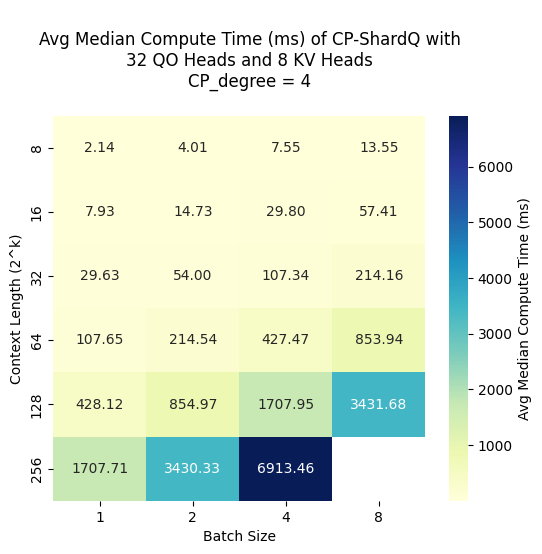

In [14]:
plt.figure(figsize=(6, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Avg Median Compute Time (ms)'})
plt.title(
    f'''
    Avg Median Compute Time (ms) of CP-ShardQ with
    {num_qo_heads} QO Heads and {num_kv_heads} KV Heads
    CP_degree = {cp_degree}
    ''')
plt.xlabel('Batch Size')
plt.ylabel('Context Length (2^k)')
plt.show()


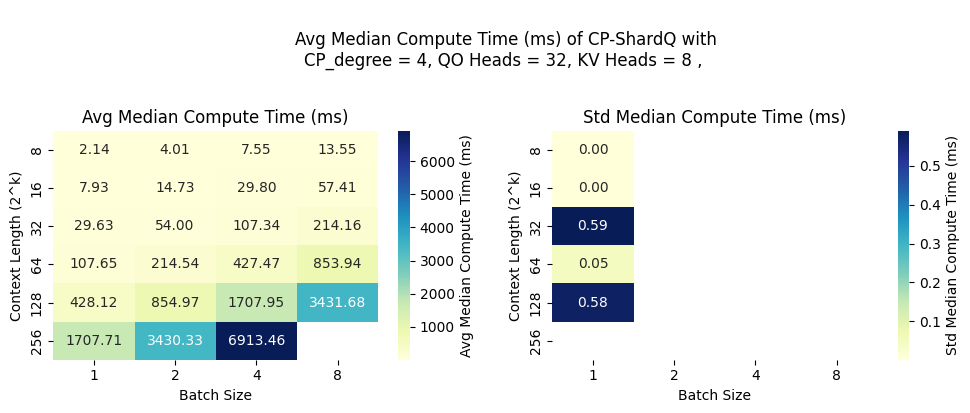

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots side by side
fig, axes = plt.subplots(ncols=2, figsize=(10, 6))

# Heatmap for avg_median_compute_time
heatmap_data_avg = aggregated_df_filtered_cp.pivot(
    index="qo_factor", 
    columns="batch_size", 
    values="avg_median_compute_time"
)
sns.heatmap(heatmap_data_avg, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Avg Median Compute Time (ms)'}, ax=axes[0])
axes[0].set_title('Avg Median Compute Time (ms)')
axes[0].set_xlabel('Batch Size')
axes[0].set_ylabel('Context Length (2^k)')

# Heatmap for std_median_compute_time
heatmap_data_std = aggregated_df_filtered_cp.pivot(
    index="qo_factor", 
    columns="batch_size", 
    values="std_median_compute_time"
)
sns.heatmap(heatmap_data_std, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Std Median Compute Time (ms)'}, ax=axes[1])
axes[1].set_title('Std Median Compute Time (ms)')
axes[1].set_xlabel('Batch Size')
axes[1].set_ylabel('Context Length (2^k)')

# Set the main title for the figure
num_qo_heads = aggregated_df_filtered_cp["num_qo_heads"].unique()[0]
num_kv_heads = aggregated_df_filtered_cp["num_kv_heads"].unique()[0]
cp_degree = aggregated_df_filtered_cp["cp_degree"].unique()[0]


fig.suptitle(title, fontsize=12,)

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.tight_layout(rect=[0, 0.30, 1, 1])
fig.savefig(f'{name}_heatmap.cp={cp_degree}.png')
plt.show()


In [16]:

aggregated_df_filtered_cp.pivot(
    index="qo_factor", 
    columns="batch_size", 
    values="value_str"
)

batch_size,1,2,4,8
qo_factor,,,,
8,2.14 ± 0.00,4.01 ± nan,7.55 ± nan,13.55 ± nan
16,7.93 ± 0.00,14.73 ± nan,29.80 ± nan,57.41 ± nan
32,29.63 ± 0.59,54.00 ± nan,107.34 ± nan,214.16 ± nan
64,107.65 ± 0.05,214.54 ± nan,427.47 ± nan,853.94 ± nan
128,428.12 ± 0.58,854.97 ± nan,1707.95 ± nan,3431.68 ± nan
256,1707.71 ± nan,3430.33 ± nan,6913.46 ± nan,NaN
